In [1]:
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from diffusers import (
    AutoencoderKL,
    T2IAdapter,
    MultiAdapter,
    StableDiffusionAdapterPipeline,
    DDPMScheduler
)

import torch
from torchvision import transforms

/n/home07/adamaraju/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


(-0.5, 511.5, 511.5, -0.5)

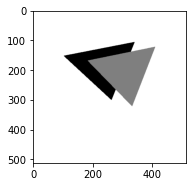

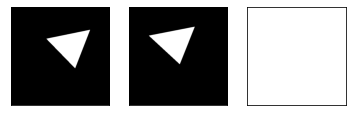

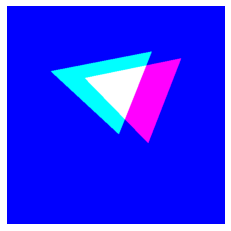

In [2]:
#Generate some generic training data real quick


import numpy as np 
import cv2
import matplotlib.pyplot as plt

def generate_triangle_sdf(H,W):
    
    
    EPS = 1e-12
    x_pos, y_pos = np.meshgrid(np.linspace(0, (H-1), H),np.linspace(0, (W-1), W))

    thresh = int(.2*W)
    len_thresh = thresh*2
    img_np = np.zeros((H, W), dtype=np.uint8)
    valid2 = False
    valid3 = False
    while valid2 == False or valid3 == False:
        x_1 = int(np.random.uniform(thresh,H-thresh))
        y_1 = int(np.random.uniform(thresh,W-thresh))

        #Compute a second point for the triangle
        x_2 = int(np.random.uniform(thresh,H-thresh))
        y_2 = int(np.random.uniform(thresh,W-thresh))
        idx = 0 
        while np.linalg.norm(np.array([x_1,y_1]) - np.array([x_2,y_2])) < len_thresh:
            if idx < 50:
                x_2 = int(np.random.uniform(thresh,H-thresh))
                y_2 = int(np.random.uniform(thresh,W-thresh))
                valid2 = True
            else:
                valid2 = False
                break

        x_3 = int(np.random.uniform(thresh,H-thresh))
        y_3 = int(np.random.uniform(thresh,W-thresh))
        idx = 0
        while (np.linalg.norm(np.array([x_1,y_1]) - np.array([x_3,y_3])) < len_thresh) or (np.linalg.norm(np.array([x_2,y_2]) - np.array([x_3,y_3])) < len_thresh):
            idx = idx +1
            if idx < 50:
                x_3 = int(np.random.uniform(thresh,H-thresh))
                y_3 = int(np.random.uniform(thresh,W-thresh)) 
                valid3 = True
            else:
                valid3 = False
                break
    
    pts_inp = np.array([[x_1, y_1], [x_2, y_2], [x_3, y_3]])
    
    oop_normal = [0,0,1]
    
    n = np.cross([x_1-x_2,y_1-y_2,0], [x_3-x_2,y_3-y_2])
    
    if np.dot(n,oop_normal) < 0:
        pts_inp = pts_inp[[0,2,1],:]
        x_2,y_2 = pts_inp[1,:]
        x_3,y_3 = pts_inp[2,:]
        
    normals = []
    ix_12 = np.linspace(x_1,x_2,500)
    m_12 = (y_2-y_1)/(x_2-x_1 + EPS)
    iy_12 = y_2 + m_12*(ix_12 - x_2)
    out_12 =  np.array([[x, y] for (x, y) in zip(ix_12, iy_12)])
    norm_12 = [np.arctan2(y_2-y_1, x_2-x_1)+np.pi/2] * len(ix_12)
    normals.extend(norm_12)
    
    ix_23 = np.linspace(x_2,x_3,500)
    m_23 = (y_3-y_2)/(x_3-x_2 + EPS)
    iy_23 = y_3 + m_23*(ix_23 - x_3)
    out_23 =  np.array([[x, y] for (x, y) in zip(ix_23, iy_23)])
    norm_23 = [np.arctan2(y_3-y_2, x_3-x_2)+np.pi/2] * len(ix_23)
    normals.extend(norm_23)
    
    ix_31 = np.linspace(x_3,x_1,500)
    m_31 = (y_1-y_3)/(x_1-x_3 + EPS)
    iy_31 = y_1 + m_31*(ix_31 - x_1)
    out_31 =  np.array([[x, y] for (x, y) in zip(ix_31, iy_31)])
    norm_31 = [np.arctan2(y_1-y_3, x_1-x_3)+np.pi/2] * len(ix_31)
    normals.extend(norm_31)
    
    #Combine all 3 ouputs
    out_pts = np.concatenate([out_12,out_23,out_31],axis=0)
    out_pts = out_pts.reshape((1, -1, 2))

    
    pts = pts_inp.reshape((1,-1,2))
    cv2.fillPoly(img_np, pts, color=255, lineType=cv2.LINE_AA)
    img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
    img = np.asarray(img/255.0,dtype=np.float32)
    img = np.asarray(img>.5,dtype=np.float32)
    normals = np.asarray(normals)
    
    return img, out_pts, normals

H=W=512

img,out_pts,normals = generate_triangle_sdf(H,W)
img = 1- img
first_img = (np.repeat(img,3,-1)* 255).astype(np.uint8)
plt.imshow(first_img)

mask_img,_,_ = generate_triangle_sdf(H,W)
mask_img = mask_img[:,:,0].astype(int)


masked_img = np.copy(img)
masked_img[mask_img==1] = .5


plt.subplot(122)
plt.imshow((np.repeat(masked_img,3,-1)* 255).astype(np.uint8),cmap='gray_r')

plt.figure()
plt.subplot(131)
fg_layer = mask_img
plt.imshow(fg_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);

plt.subplot(132)
mid_layer = (1-img).squeeze()
plt.imshow(mid_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);

plt.subplot(133)
bg_layer = np.ones(mid_layer.shape)
plt.imshow(bg_layer,cmap='gray',vmin=0,vmax=1)
plt.xticks([]);plt.yticks([]);

plt.figure()
layer_img = np.stack([fg_layer,mid_layer,bg_layer],axis=-1)
plt.imshow(layer_img)
plt.axis('off')

In [3]:
DATASET_SIZE=10
H=W=512

layer_binaries = []
layer_imgs = []
base_imgs = []

def gray2rgb(img):
    return (np.repeat(img,3,-1)* 255).astype(np.uint8)

for itr in range(DATASET_SIZE):
    img,_,_ = generate_triangle_sdf(H,W)
    img = 1- img
    
    #Mask (foreground layer)
    mask_img,_,_ = generate_triangle_sdf(H,W)
    mask_img = mask_img[:,:,0].astype(int)

    #Plain background layer
    bg_layer = np.ones([H,W])
    
    #Compositing full image
    masked_img = np.copy(img)
    masked_img[mask_img==1] = .5
    
    #Compositing layer map
    fg_layer = mask_img
    mid_layer = (1-img).squeeze()
    layer_bin = np.stack([fg_layer,mid_layer,bg_layer],axis=-1)

    #add to lists
    layer_binaries.append(layer_bin)
    layer_imgs.append((gray2rgb(1-fg_layer[...,np.newaxis]*.5),
                       gray2rgb(1-mid_layer[...,np.newaxis]),
                       gray2rgb(bg_layer[...,np.newaxis])))
    base_imgs.append(gray2rgb(masked_img))
    
    if itr%200 == 0:
        print(itr)
    

0


In [4]:
layer_imgs[0][0].shape

(512, 512, 3)

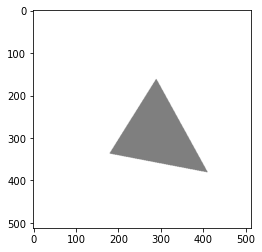

In [5]:
# plt.imshow(layer_imgs[0][2])
plt.imshow(layer_imgs[0][0])

In [6]:
# Also need to generate some utils for the training for the layering maps
# For example need some code that combines all layer maps below a layer and all above a layer
# Also need analagous code that does this for the layered  objects in the image

def get_front_layers(layer_imgs, layer_bin, layer_no):
    num_layers = len(layer_imgs) -1 #subtract 1 for loops??
    front_layers = np.ones(layer_imgs[0].shape)
    front_bin = np.zeros(layer_bin.shape)
    if layer_no == num_layers:
        return front_layers,front_bin
    else:
        for layer_idx in range(layer_no,num_layers):
            front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
            front_bin[layer_bin==1] = 1
        return front_layers,front_bin
        

def get_back_layer(layer_imgs, layer_bin, layer_no):
    num_layers = len(layer_imgs) - 1
    back_layers = np.ones(layer_imgs[0].shape)
    back_bin = np.zeros(layer_bin.shape)
    for layer_idx in range(layer_no):
        #FINISH / FIX THIS CODE AT SOMEPOINT
        front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
        front_bin[layer_bin==1] = 1
    return front_layers,front_bin

In [7]:
import torch
import torch.nn as nn

## Network that takes 4 dimensional input and pushes it to 3 dimensions for the vae
class ContractNet(nn.Module):
    def __init__(self):
        super(ContractNet, self).__init__()
        self.conv = nn.Conv2d(4, 3, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

    

## Network that takes 3 dimensional input and pushes it to 4 dimensions for model out
class ExpandNet(nn.Module):
    def __init__(self):
        super(ExpandNet, self).__init__()
        self.conv = nn.Conv2d(3, 4, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [8]:
#Instantiate the two adapters and the pretrained model

# An adapter that takes in the original image (or a subset of layers)
RGB_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

# An adapter that takes in the mask given by the layers above the current one
mask_adapter = T2IAdapter(channels_in=int(1), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

#Combine them into a single adapter
# adapter = MultiAdapter([RGB_adapter,mask_adapter])
adapter = RGB_adapter

#Instantiate the Convolutional layers
contract_layer = ContractNet()
expand_layer = ExpandNet()

#Pretrained stable diffusion model that we will try not to touch (may end up changing the final conv_out though.
#To be honest I am really hoping this works

model_name = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionAdapterPipeline.from_pretrained(model_name, torch_dtype=torch.float32).to('cuda')

vae = pipe.vae
unet = pipe.unet
# also get the clip model because it matters probably....

#But looks like it may not work as just the model for training so we have to separate it into parts for training anyway

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [9]:
noise_scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")
# text_encoder = text_encoder_cls.from_pretrained(
    # args.pretrained_model_name_or_path, subfolder="text_encoder")

In [10]:
#Random point, what if I dont do anything about the masking etc, and just try and make a model that removes the top object in a scene, or like just tries to get the layer mappings?

In [13]:

def make_train_dataset(args):
    # Get the datasets: you can either provide your own training and evaluation files (see below)
    # or specify a Dataset from the hub (the dataset will be downloaded automatically from the datasets Hub).

    # In distributed training, the load_dataset function guarantees that only one local process can concurrently
    # download the dataset.
    if args.dataset_name is not None:
        # Downloading and loading a dataset from the hub.
        dataset = load_dataset(
            args.dataset_name,
            args.dataset_config_name,
            cache_dir=args.cache_dir,
        )
    else:
        if args.train_data_dir is not None:
            dataset = load_dataset(
                args.train_data_dir,
                cache_dir=args.cache_dir,
            )
        # See more about loading custom images at
        # https://huggingface.co/docs/datasets/v2.0.0/en/dataset_script

    # Preprocessing the datasets.
    # We need to tokenize inputs and targets.
    column_names = dataset["train"].column_names

    # 6. Get the column names for input/target.
    if args.image_column is None:
        image_column = column_names[0]
        print(f"image column defaulting to {image_column}")
    else:
        image_column = args.image_column
        if image_column not in column_names:
            raise ValueError(
                f"`--image_column` value '{args.image_column}' not found in dataset columns. Dataset columns are: {', '.join(column_names)}"
            )

    if args.caption_column is None:
        caption_column = column_names[1]
        print(f"caption column defaulting to {caption_column}")
    else:
        caption_column = args.caption_column
        if caption_column not in column_names:
            raise ValueError(
                f"`--caption_column` value '{args.caption_column}' not found in dataset columns. Dataset columns are: {', '.join(column_names)}"
            )

    if args.conditioning_image_column is None:
        conditioning_image_column = column_names[2]
        print(f"conditioning image column defaulting to {conditioning_image_column}")
    else:
        conditioning_image_column = args.conditioning_image_column
        if conditioning_image_column not in column_names:
            raise ValueError(
                f"`--conditioning_image_column` value '{args.conditioning_image_column}' not found in dataset columns. Dataset columns are: {', '.join(column_names)}"
            )

    # def tokenize_captions(examples, is_train=True):
    #     captions = []
    #     for caption in examples[caption_column]:
    #         if random.random() < args.proportion_empty_prompts:
    #             captions.append("")
    #         elif isinstance(caption, str):
    #             captions.append(caption)
    #         elif isinstance(caption, (list, np.ndarray)):
    #             # take a random caption if there are multiple
    #             captions.append(random.choice(caption) if is_train else caption[0])
    #         else:
    #             raise ValueError(
    #                 f"Caption column `{caption_column}` should contain either strings or lists of strings."
    #             )
    #     inputs = tokenizer(
    #         captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    #     )
    #     return inputs.input_ids

    image_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    conditioning_image_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution),
            transforms.ToTensor(),
        ]
    )

    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        images = [image_transforms(image) for image in images]

        conditioning_images = [image.convert("RGB") for image in examples[conditioning_image_column]]
        conditioning_images = [conditioning_image_transforms(image) for image in conditioning_images]

        examples["pixel_values"] = images
        examples["conditioning_pixel_values"] = conditioning_images
        # examples["input_ids"] = tokenize_captions(examples)

        return examples

    # with accelerator.main_process_first():
    if args.max_train_samples is not None:
        dataset["train"] = dataset["train"].shuffle(seed=args.seed).select(range(args.max_train_samples))
    # Set the training transforms
    train_dataset = dataset["train"].with_transform(preprocess_train)

    return train_dataset


In [26]:
dataset

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'dataset' is not defined

In [11]:
dataset = load_dataset(args.dataset_name)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'load_dataset' is not defined

In [14]:
from types import SimpleNamespace
from datasets import load_dataset

args = SimpleNamespace()

args.dataset_name = "fusing/fill50k"
args.train_data_dir = None #"../ControlNet/training/fill50k"
args.dataset_config_name=None
args.cache_dir = None
args.image_column = "image"
args.caption_column = "text"
args.conditioning_image_column = "conditioning_image"
args.resolution = 512
args.max_train_samples = 1000
args.seed = None
args.train_batch_size = 4
args.dataloader_num_workers = 0

In [15]:
train_data = make_train_dataset(args)

No config specified, defaulting to: fill50k/default
Found cached dataset fill50k (/n/home07/adamaraju/.cache/huggingface/datasets/fusing___fill50k/default/0.0.2/f23b778406682a796a540934e7163495e1b8a88fefc76ca08f7e5a79ddcd668b)


  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    conditioning_pixel_values = torch.stack([example["conditioning_pixel_values"] for example in examples])
    conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()

    # input_ids = torch.stack([example["input_ids"] for example in examples])

    return {
        "pixel_values": pixel_values,
        "conditioning_pixel_values": conditioning_pixel_values,
        # "input_ids": input_ids,
    }

In [17]:
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=args.train_batch_size,
    num_workers=args.dataloader_num_workers,
)

In [17]:
for step, batch in enumerate(train_dataloader):
    print(batch["pixel_values"].shape)
    break

torch.Size([4, 3, 512, 512])


In [59]:
#Instantiate the Convolutional layers

contract_layer = ContractNet().to("cuda")
expand_layer = ExpandNet().to("cuda")

In [18]:
#Set optimizer class
# params_to_optimize = list(contract_layer.parameters()) + list(expand_layer.parameters()) + list(adapter.parameters())
params_to_optimize =adapter.parameters()

optimizer_class = torch.optim.AdamW
optimizer = optimizer_class(
    params_to_optimize,
    lr = 1e-3,#lr=args.learning_rate,
    #betas=(args.adam_beta1, args.adam_beta2),
    #weight_decay=args.adam_weight_decay,
    #eps=args.adam_epsilon,
) #put args/ optimizer class here!!

In [19]:
plt.imshow()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: imshow() missing 1 required positional argument: 'X'

In [20]:
test1 = torch.tensor(layer_imgs[0][1]).permute(2,0,1)
test2 = torch.tensor(layer_binaries[0][...,0]).unsqueeze(0)
test_T = torch.cat([test1,test2],axis=0).to("cuda:0")
test_T = test_T.unsqueeze(0)
weight_dtype = torch.float32
# contract_in = contract_layer(test_T.to(dtype=weight_dtype))

In [21]:
bsz = 4
val1 = test1.unsqueeze(0).to('cuda').repeat(bsz,1,1,1)

In [22]:
val1.shape

torch.Size([4, 3, 512, 512])

In [23]:
in1.shape

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'in1' is not defined

In [24]:
condition_img = torch.tensor(base_imgs[0]).permute(2,0,1).unsqueeze(0).to(torch.float)
condition_mask = torch.tensor(layer_binaries[0][...,-1]).unsqueeze(0).unsqueeze(0).to(torch.float)
# conditional_in = torch.cat([in1,in2],axis=0).to("cuda:0")
# conditional_in = conditional_in.unsqueeze(0)

In [25]:
conditional_in.shape

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'conditional_in' is not defined

In [26]:
contract_in.shape

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'contract_in' is not defined

In [27]:
latents = vae.encode(val1.to(dtype=weight_dtype)).latent_dist.sample()

In [28]:
latents.shape

torch.Size([4, 4, 64, 64])

In [29]:
# Sample noise that we'll add to the latents
noise = torch.randn_like(latents)
bsz = latents.shape[0]
# Sample a random timestep for each image
timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
timesteps = timesteps.long()

# Add noise to the latents according to the noise magnitude at each timestep
# (this is the forward diffusion process)
noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

In [30]:
noisy_latents.shape

torch.Size([4, 4, 64, 64])

In [31]:
condition_img.shape

torch.Size([1, 3, 512, 512])

In [32]:
adapter_input = condition_img.repeat(bsz,1,1,1)

#MultiAdapter stuff
# n, c, h, w = adapter_input[0].shape
# adapter_input = torch.stack([x.reshape([n * x.shape[1], h, w]) for x in adapter_input])

#CHANGE THE CODE SO I CAN GIVE IT A LIST OF adapters or just slice correctly

adapter_state = adapter(adapter_input)
# len(out)

In [33]:
adapter_input.shape

torch.Size([4, 3, 512, 512])

In [34]:
do_classifier_free_guidance= False

In [52]:
for k, v in enumerate(adapter_state):
    adapter_state[k] = v.to("cuda")#* adapter_conditioning_scale
if do_classifier_free_guidance:
    for k, v in enumerate(adapter_state):
        adapter_state[k] = torch.cat([v] * 2, dim=0).to("cuda")

In [36]:
noisy_latents = torch.cat([noisy_latents] * 2) if do_classifier_free_guidance else noisy_latents

In [37]:
# # adapter_state = adapter(adapter_input)
# for k, v in enumerate(adapter_state):
#     adapter_state[k] = v * adapter_conditioning_scale
# if num_images_per_prompt > 1:
#     for k, v in enumerate(adapter_state):
#         adapter_state[k] = v.repeat(num_images_per_prompt, 1, 1, 1)
# if do_classifier_free_guidance:
#     for k, v in enumerate(adapter_state):
#         adapter_state[k] = torch.cat([v] * 2, dim=0)

# # ## expand the latents if we are doing classifier free guidance
# # noisy_latents = torch.cat([noisy_latents] * 2) if do_classifier_free_guidance else latents

In [38]:
adapter_state[k].device

device(type='cpu')

In [43]:
prompt_embeds = pipe._encode_prompt(
    "",
    device="cuda",
    num_images_per_prompt = bsz ,
    do_classifier_free_guidance=do_classifier_free_guidance,
    negative_prompt=None,
    prompt_embeds=None,
    negative_prompt_embeds=None,
)


In [44]:
prompt_embeds.shape

torch.Size([4, 77, 768])

In [45]:
noisy_latents.shape

torch.Size([4, 4, 64, 64])

In [46]:
 adapter_state[k].shape

torch.Size([4, 1280, 8, 8])

In [47]:
timesteps.shape

torch.Size([4])

In [53]:
adapter_state[k].device

device(type='cuda', index=0)

In [54]:
with torch.no_grad():
    noise_pred = unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=prompt_embeds,
            cross_attention_kwargs=None,
            down_block_additional_residuals=[state.clone() for state in adapter_state],
    ).sample

In [70]:
noisy_latents.shape[0]

8

In [45]:
noise_pred.shape

torch.Size([2, 4, 64, 64])

In [147]:
import torch.nn.functional as F
loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")
optimizer.step()

<ipython-input-147-7f51ce7b94b8>:2: UserWarning: Using a target size (torch.Size([1, 4, 64, 64])) that is different to the input size (torch.Size([2, 4, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")


In [3]:
#Set optimizer class
optimizer_class = torch.optim.AdamW

#Get parameters to optimize
params_to_optimize = list(contract_layer.parameters()) + list(expand_layer.parameters()) + list(adapter.parameters())
optimizer = optimizer_class(
    params_to_optimize,
    lr = 1e-3,#lr=args.learning_rate,
    #betas=(args.adam_beta1, args.adam_beta2),
    #weight_decay=args.adam_weight_decay,
    #eps=args.adam_epsilon,
) #put args/ optimizer class here!!

# Also add two tiny networks that are a conv2D with 1 kernel size and 1 stride, going from 3 to 4 dimensions
# Pipeline
### IN PARALLEL: turn image + mask into 4d mask -> 4d mask to 3d using convolution -> 3d to latent with vae
### IN PARALLEL: layer image + other mask into 2 part adapter
### get unet and put both models into this
## back prop and thats it!!


# additional, try to figure out accelerator
# additional work on getting saving for outputs, see if i can get it to work..


# Train!
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

# Potentially load in the weights and states from a previous save
if args.resume_from_checkpoint:
    if args.resume_from_checkpoint != "latest":
        path = os.path.basename(args.resume_from_checkpoint)
    else:
        # Get the most recent checkpoint
        dirs = os.listdir(args.output_dir)
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
        path = dirs[-1] if len(dirs) > 0 else None

    if path is None:
        accelerator.print(
            f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
        )
        args.resume_from_checkpoint = None
        initial_global_step = 0
    else:
        accelerator.print(f"Resuming from checkpoint {path}")
        accelerator.load_state(os.path.join(args.output_dir, path))
        global_step = int(path.split("-")[1])

        initial_global_step = global_step
        first_epoch = global_step // num_update_steps_per_epoch
else:
    initial_global_step = 0

progress_bar = tqdm(
    range(0, args.max_train_steps),
    initial=initial_global_step,
    desc="Steps",
    # Only show the progress bar once on each machine.
    # disable=not accelerator.is_local_main_process,
)

weight_dtype = torch.float32
image_logs = None
for epoch in range(first_epoch, args.num_train_epochs):
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(controlnet):
            #### Convert images to latent space
            #network that goes from four to three dimensions
            contract_in = contract_layer(batch["pixel_values"].to(dtype=weight_dtype))
            latents = vae.encode(contract_in).latent_dist.sample()
            latents = latents * vae.config.scaling_factor
            
            
            # 5. Prepare latent variables
            # one possible option
            # latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
            # latents = latents * vae.config.scaling_factor
            # 
            
            # num_channels_latents = self.unet.in_channels + 1 ##ADDED 1 ( 3->4)
#             latents = self.prepare_latents(
#                 batch_size * num_images_per_prompt,
#                 num_channels_latents,
#                 height,
#                 width,
#                 prompt_embeds.dtype,
#                 device,
#                 generator,
#                 latents,
#             )
            
            
            
            
            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"])[0]

            # controlnet_image = batch["conditioning_pixel_values"].to(dtype=weight_dtype)

#             down_block_res_samples, mid_block_res_sample = controlnet(
#                 noisy_latents,
#                 timesteps,
#                 encoder_hidden_states=encoder_hidden_states,
#                 controlnet_cond=controlnet_image,
#                 return_dict=False,
#             )

#             # Predict the noise residual
#             model_pred = unet(
#                 noisy_latents,
#                 timesteps,
#                 encoder_hidden_states=encoder_hidden_states,
#                 down_block_additional_residuals=[
#                     sample.to(dtype=weight_dtype) for sample in down_block_res_samples
#                 ],
#                 mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
#             ).sample
            
    
            # 7. Denoising loop
            adapter_state = self.adapter(adapter_input)
            for k, v in enumerate(adapter_state):
                adapter_state[k] = v * adapter_conditioning_scale
            if num_images_per_prompt > 1:
                for k, v in enumerate(adapter_state):
                    adapter_state[k] = v.repeat(num_images_per_prompt, 1, 1, 1)
            if do_classifier_free_guidance:
                for k, v in enumerate(adapter_state):
                    adapter_state[k] = torch.cat([v] * 2, dim=0)

            ## expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

            # predict the noise residual
            noise_pred = unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                    down_block_additional_residuals=[state.clone() for state in adapter_state],
            ).sample
    
            # Add something here that is consistent with increasing the dimensionality of the model from three to four dimensions
            # something like noisy_out = depth_conv(noise_pred)
            
            
            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

            # loss backward
            # accelerator.backward(loss)
            # if accelerator.sync_gradients:
            #     params_to_clip = controlnet.parameters()
            #     accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad(set_to_none=args.set_grads_to_none)

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

            if accelerator.is_main_process:
                if global_step % args.checkpointing_steps == 0:
                    # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                    if args.checkpoints_total_limit is not None:
                        checkpoints = os.listdir(args.output_dir)
                        checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                        checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                        # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                        if len(checkpoints) >= args.checkpoints_total_limit:
                            num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                            removing_checkpoints = checkpoints[0:num_to_remove]

                            logger.info(
                                f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                            )
                            logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                            for removing_checkpoint in removing_checkpoints:
                                removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                shutil.rmtree(removing_checkpoint)

                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

                if args.validation_prompt is not None and global_step % args.validation_steps == 0:
                    image_logs = log_validation(
                        vae,
                        text_encoder,
                        tokenizer,
                        unet,
                        controlnet,
                        args,
                        accelerator,
                        weight_dtype,
                        global_step,
                    )

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= args.max_train_steps:
            break

# Create the pipeline using using the trained modules and save it.
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    controlnet = accelerator.unwrap_model(controlnet)
    controlnet.save_pretrained(args.output_dir)

    if args.push_to_hub:
        save_model_card(
            repo_id,
            image_logs=image_logs,
            base_model=args.pretrained_model_name_or_path,
            repo_folder=args.output_dir,
        )
        upload_folder(
            repo_id=repo_id,
            folder_path=args.output_dir,
            commit_message="End of training",
            ignore_patterns=["step_*", "epoch_*"],
        )

accelerator.end_training()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'adapter' is not defined